# このnotebookについて


# 事前準備

In [1]:
import os
import json

import numpy as np


In [2]:
# 自作モジュールの読み込み
from modules.file_format.HDF5 import HDF5Reader, HDF5Writer
from modules.app_utils.setting_handler import RunListMaster
from modules.file_format.spe_wrapper import SpeWrapper


In [3]:
"""pathの設定"""
import sys
repository_root = None
for sys_path in sys.path:
    if sys_path.endswith('LAMBDA-Melting'):
        repository_root = sys_path
if repository_root is None:
    raise ValueError('repository_root is not set')

"""plot用の設定"""
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'     #数式用のフォントejavuserif" or "cm"
plt.rcParams['xtick.direction'] = 'in'      #x軸の目盛線 #内in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'      #y軸の目盛線 #内in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0     #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0     #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 14               #フォントの大きさ
plt.rcParams['axes.linewidth'] = 0.8        #軸の線幅edge linewidth。囲みの太さ
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8, 6)
# Arialフォントを設定
plt.rcParams.update({
    "font.family": "Arial",           # フォントをArialに設定
    "mathtext.fontset": "custom",     # カスタムフォントを指定
    "mathtext.rm": "Arial",           # 数式の通常テキスト部分
    "mathtext.it": "Arial",    # 数式のイタリック部分
    "mathtext.bf": "Arial"       # 数式の太字部分
})

# 読み込み先の設定

## 選んだRunを読み込み

In [4]:
# runの読み込み
# Run Selectorで選択したことを想定する
path_to_run_setting = os.path.join(repository_root, 'settings', 'run_selector.json')
with open(path_to_run_setting) as json_file:
    selected_run_setting = json.load(json_file)

In [5]:
selected_run_setting

{'data_root_path': '/Users/ishizawaosamu/work/MasterThesis/data',
 'current_run': 'OIbDia08_2nd',
 'path_to_run_files': '/Users/ishizawaosamu/work/MasterThesis/data/BDD/OIbDia08/2nd',
 'selected_files': {'Temperature': {'raw_radiation': 'OIbDia08_ 04.spe',
   'dist': 'OIbDia08_ 04_separate_half_p45e-2_dist.hdf'},
  'XRD': {'data': 'OIbDia08_4_00000.nxs',
   'calibration': 'pyFAI_calib2_MgS400_CeO2_240511.poni'}},
 'is_overwritten': False,
 'save_root_path': '/Users/ishizawaosamu/work/MasterThesis/save'}

## 温度データを読み込み

In [6]:
path_to_dist = os.path.join(
    selected_run_setting['path_to_run_files'],
    selected_run_setting['selected_files']['Temperature']['dist']
)
dist_hdf = HDF5Reader(path_to_dist)

HDF5ファイルが見つかりました: /Users/ishizawaosamu/work/MasterThesis/data/BDD/OIbDia08/2nd/OIbDia08_ 04_separate_half_p45e-2_dist.hdf


In [7]:
spe = SpeWrapper(os.path.join(
    selected_run_setting['path_to_run_files'],
    selected_run_setting['selected_files']['Temperature']['raw_radiation']
))
spe.get_params_from_xml()
spe.framerate

40.325222922872975

## 配列を作成する処理

In [8]:
dist_hdf.path_list

['entry/error/T',
 'entry/error/scale',
 'entry/spe/2d_max_intensity',
 'entry/value/T',
 'entry/value/scale']

In [9]:
# 温度mapとradiation強度を読み込む
dist_array = dist_hdf.find_by(query='value/T')
dist_array[dist_array > 10_000] = 0 # ここで変な値は切っておく

T_error_array = dist_hdf.find_by(query='error/T')
T_error_array[T_error_array > 500] = 0 # planck fitのエラーは小さいはず

radiation_array = dist_hdf.find_by(query='spe/2d_max_intensity')

「value/T」で検索します。
	-> entry/value/T を返しました。
「error/T」で検索します。
	-> entry/error/T を返しました。
「spe/2d_max_intensity」で検索します。
	-> entry/spe/2d_max_intensity を返しました。


In [10]:
# 温度データの形状を取得しておく
frame_num, position_num = dist_array.shape
# 配列を作っておく
frame_array = np.arange(frame_num)
frame_num, position_num

(800, 512)

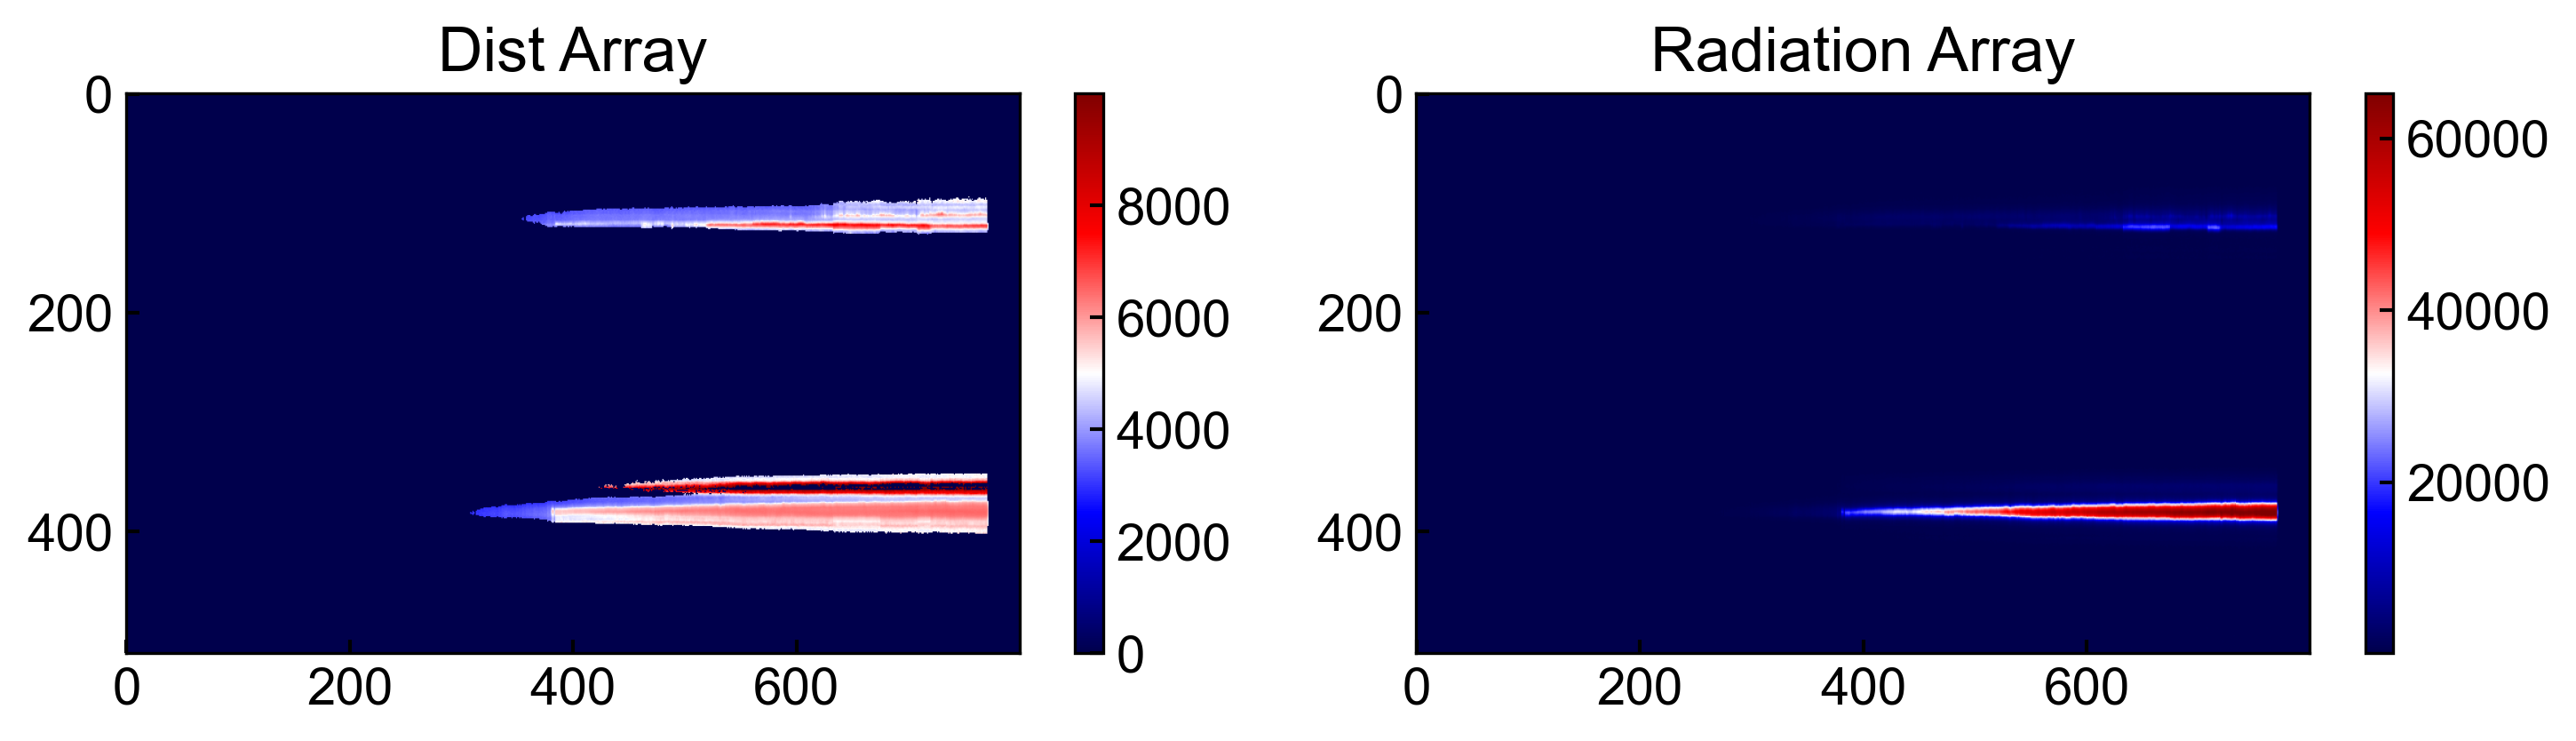

In [11]:
# 視覚化
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
im1 = axes[0].imshow(dist_array.T, cmap='seismic', aspect='auto')
axes[0].set_title("Dist Array")
fig.colorbar(im1, ax=axes[0], orientation='vertical')  # カラーバーの追加
im2 = axes[1].imshow(radiation_array.T, cmap='seismic', aspect='auto')
axes[1].set_title("Radiation Array")
fig.colorbar(im2, ax=axes[1], orientation='vertical')  # カラーバーの追加
plt.tight_layout()  # レイアウトを調整
plt.show()

In [12]:
# 最大位置を調べる
up_max_position_arr = np.argmax(radiation_array[:, :round(position_num/2)], axis=1)
down_max_position_arr = np.argmax(radiation_array[:, round(position_num/2):], axis=1) + round(position_num/2)

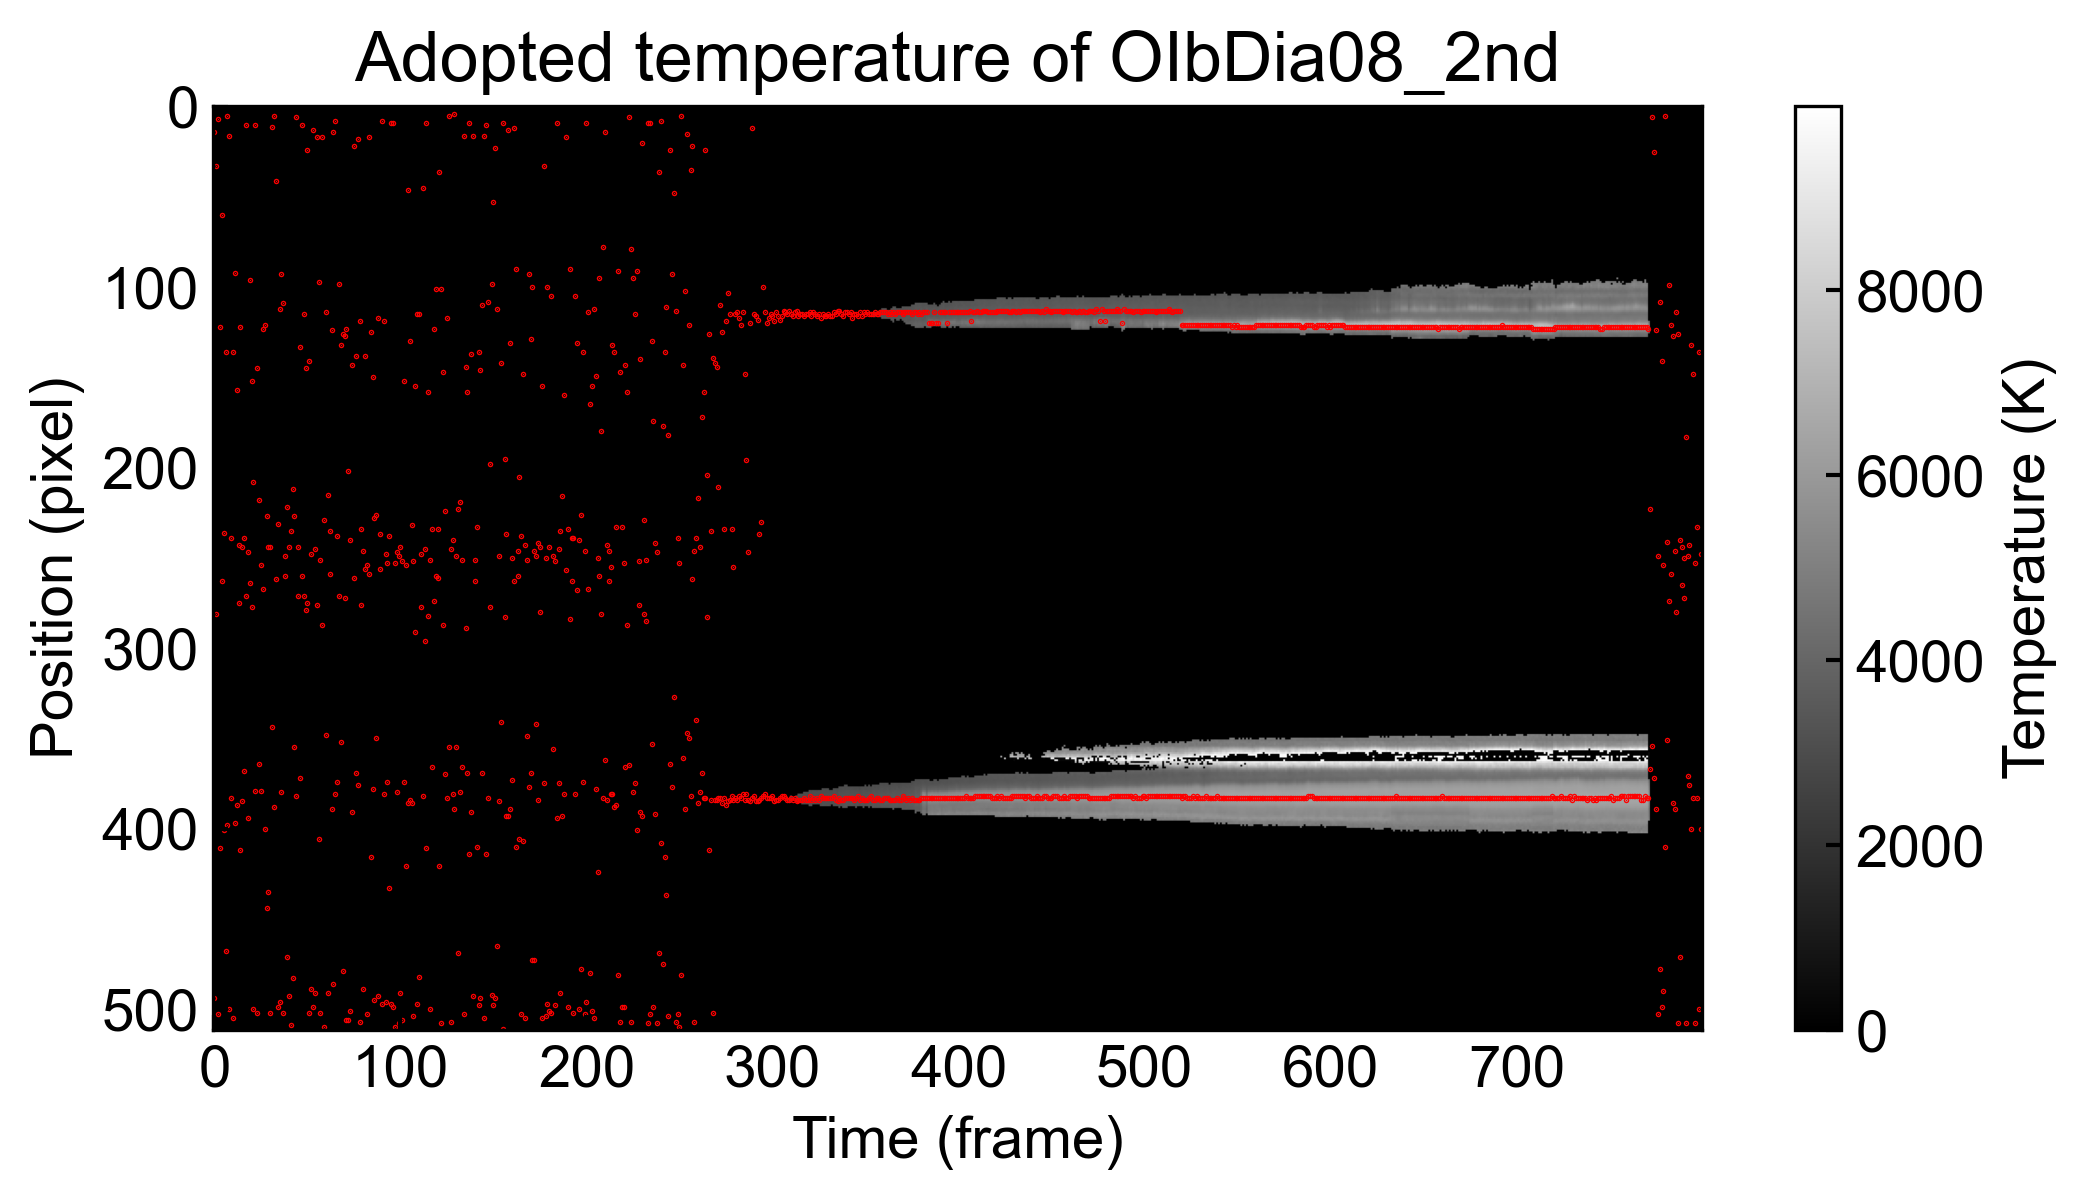

In [25]:
# 露光強度をもとにした採用温度点
plt.figure(figsize=(8, 4))
plt.imshow(dist_array.T, cmap='gray', aspect='auto')
plt.colorbar(label='Temperature (K)')
plt.scatter(frame_array, up_max_position_arr, c='red', s=0.1)
plt.scatter(frame_array, down_max_position_arr, c='red', s=0.1)
plt.xlabel('Time (frame)')
plt.ylabel('Position (pixel)')
plt.title(f'Adopted temperature of {selected_run_setting['current_run']}')
plt.savefig(os.path.join(selected_run_setting['save_root_path'], 'fig', 'T_adopted_position', selected_run_setting['current_run']+'.png'))
plt.show()
plt.close()


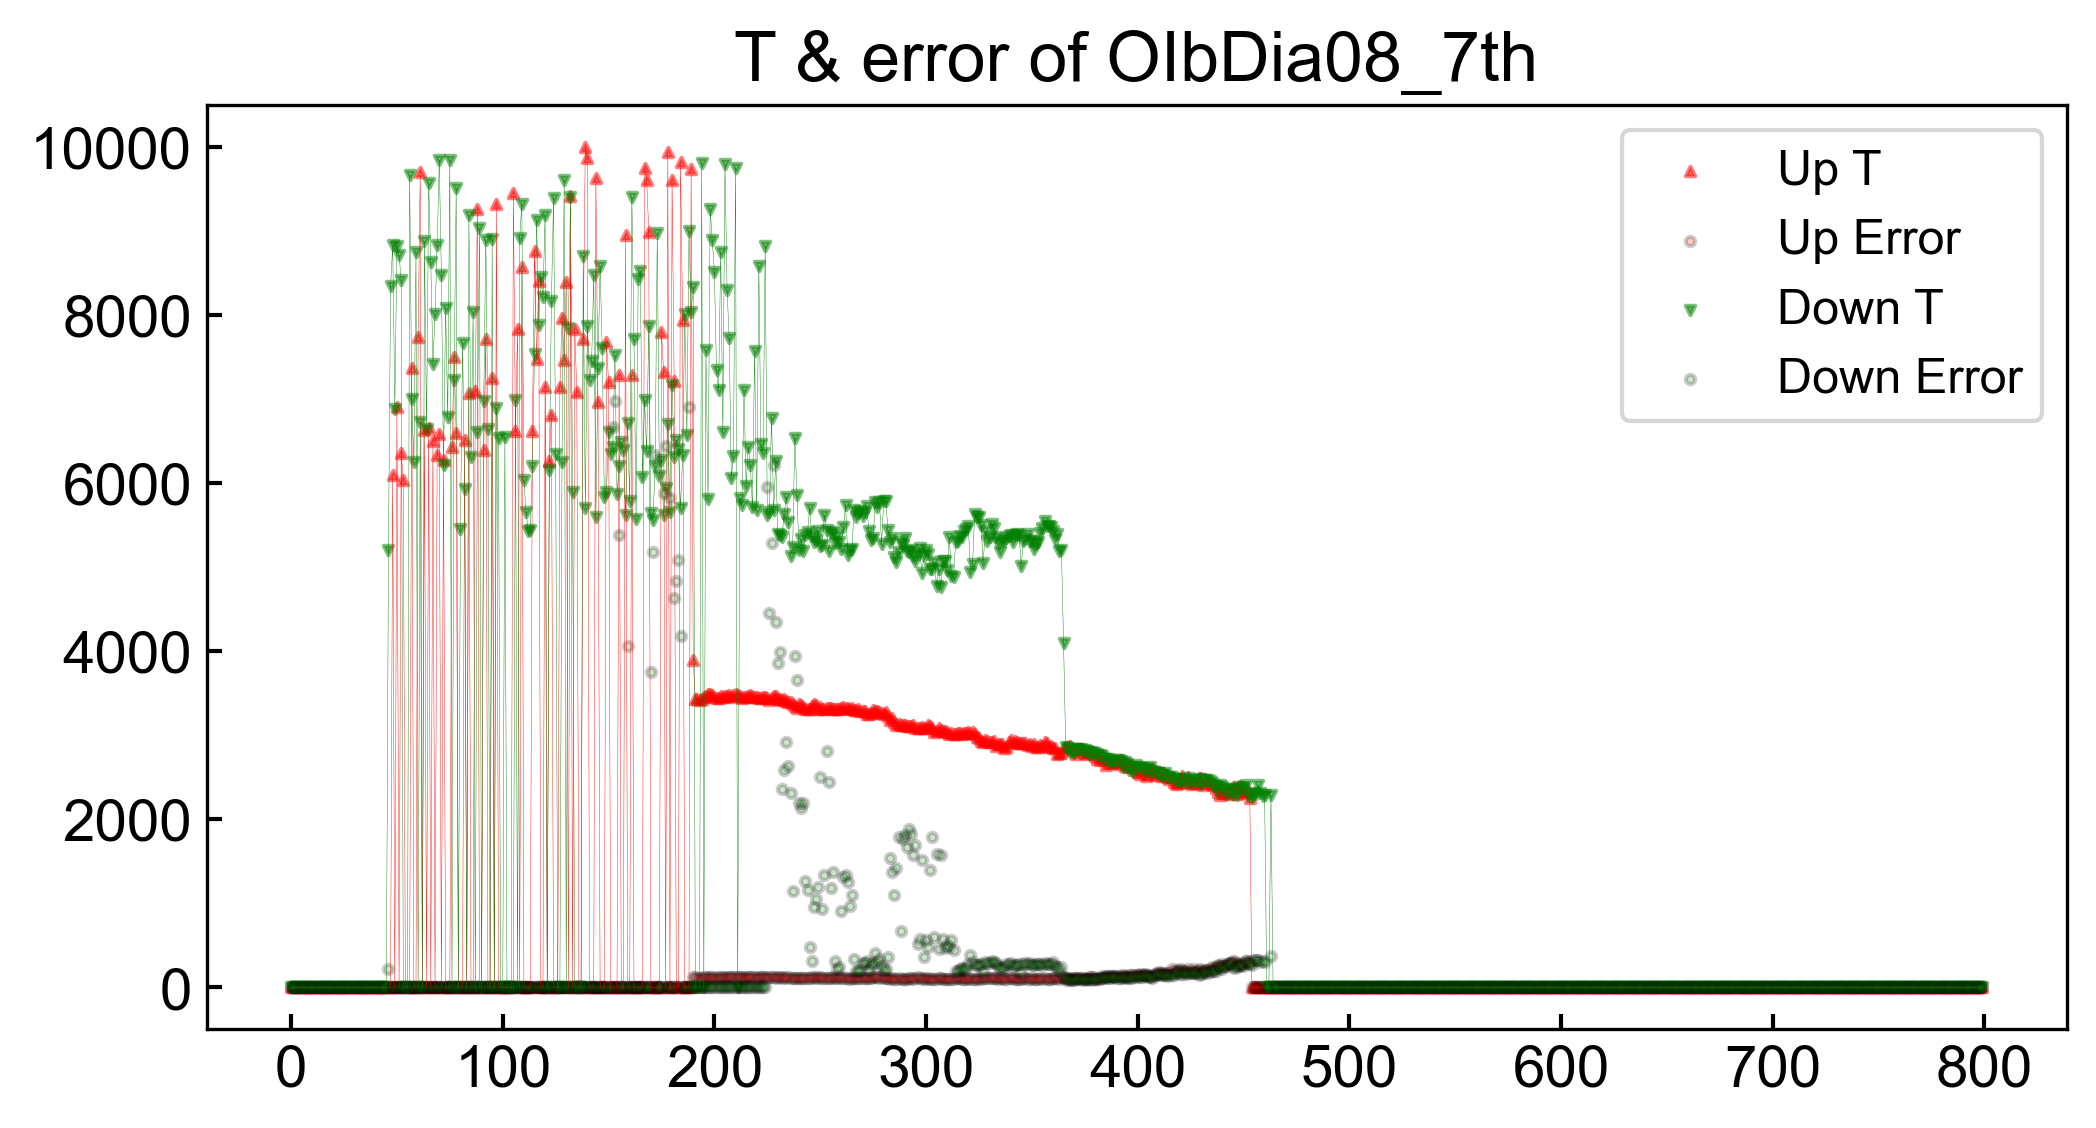

In [142]:
# 各フレームの最大位置に対応する温度値を取得
up_measured_T_array = dist_array[frame_array, up_max_position_arr]
down_measured_T_array = dist_array[frame_array, down_max_position_arr]
# エラーも
up_measured_error_array = T_error_array[frame_array, up_max_position_arr] * 14
down_measured_error_array = T_error_array[frame_array, down_max_position_arr] * 14

plt.figure(figsize=(8, 4))
plt.scatter(frame_array, up_measured_T_array, c='red', alpha=0.5, s=5, marker='^', label='Up T')
plt.plot(frame_array, up_measured_T_array, c='red', linewidth=0.1)
plt.scatter(frame_array, up_measured_error_array, c='red', alpha=0.2, s=5, marker='o', edgecolor='k', label='Up Error')
plt.scatter(frame_array, down_measured_T_array, c='green', alpha=0.5, s=5, marker='v', label='Down T')
plt.plot(frame_array, down_measured_T_array, c='green', linewidth=0.1)
plt.scatter(frame_array, down_measured_error_array, c='green', alpha=0.2, s=5, marker='o', edgecolor='k', label='Down Error')
plt.legend(fontsize='small')
plt.title(f'T & error of {selected_run_setting['current_run']}')
# plt.ylim(0, 8_000)
plt.savefig(os.path.join(selected_run_setting['save_root_path'], 'fig', 'measured_T_&_error', selected_run_setting['current_run']+'.png'))
plt.show()
plt.close()

# 書き込み先の設定

In [143]:
# 上書きするかどうかを設定
is_overwritten = selected_run_setting['is_overwritten']
is_overwritten

False

In [144]:
# HDF
# run_name_processed.hdfを作成する。すでにあればそれが読み込まれる
up_saved_hdf = HDF5Writer(
    file_path=os.path.join(
        selected_run_setting['save_root_path'],
        'processed_hdf',
        f'{selected_run_setting["current_run"]}_up_processed.hdf'
    )
)

down_saved_hdf = HDF5Writer(
    file_path=os.path.join(
        selected_run_setting['save_root_path'],
        'processed_hdf',
        f'{selected_run_setting["current_run"]}_down_processed.hdf'
    )
)


ファイルが見つかりません。: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_up_processed.hdf
HDF5ファイルが作成されました: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_up_processed.hdf
ファイルが見つかりません。: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_down_processed.hdf
HDF5ファイルが作成されました: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_down_processed.hdf


In [145]:
# up
# 配列を保存
up_saved_hdf.write(data_path='entry/measured/value/T', data=up_measured_T_array, overwrite=is_overwritten)
up_saved_hdf.write(data_path='entry/measured/error/T', data=up_measured_error_array, overwrite=is_overwritten)
up_saved_hdf.write(data_path='entry/measured/value/frame_T', data=frame_array, overwrite=is_overwritten)
up_saved_hdf.write(data_path='entry/measured/value/max_position_T', data=up_max_position_arr, overwrite=is_overwritten)

# パラメータを保存
up_saved_hdf.write(data_path='entry/params/framerate/T', data=spe.framerate, overwrite=is_overwritten)
up_saved_hdf.write(data_path='entry/params/frame/T', data=frame_num, overwrite=is_overwritten)

書き込みに成功しました: 'entry/measured/value/T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_up_processed.hdf
書き込みに成功しました: 'entry/measured/error/T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_up_processed.hdf
書き込みに成功しました: 'entry/measured/value/frame_T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_up_processed.hdf
書き込みに成功しました: 'entry/measured/value/max_position_T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_up_processed.hdf
書き込みに成功しました: 'entry/params/framerate/T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_up_processed.hdf
書き込みに成功しました: 'entry/params/frame/T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_up_processed.hdf


In [146]:
# down
# 配列を保存
down_saved_hdf.write(data_path='entry/measured/value/T', data=down_measured_T_array, overwrite=is_overwritten)
down_saved_hdf.write(data_path='entry/measured/error/T', data=down_measured_error_array, overwrite=is_overwritten)
down_saved_hdf.write(data_path='entry/measured/value/frame_T', data=frame_array, overwrite=is_overwritten)
down_saved_hdf.write(data_path='entry/measured/value/max_position_T', data=down_max_position_arr, overwrite=is_overwritten)

# パラメータを保存
down_saved_hdf.write(data_path='entry/params/framerate/T', data=spe.framerate, overwrite=is_overwritten)
down_saved_hdf.write(data_path='entry/params/frame/T', data=frame_num, overwrite=is_overwritten)

書き込みに成功しました: 'entry/measured/value/T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_down_processed.hdf
書き込みに成功しました: 'entry/measured/error/T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_down_processed.hdf
書き込みに成功しました: 'entry/measured/value/frame_T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_down_processed.hdf
書き込みに成功しました: 'entry/measured/value/max_position_T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_down_processed.hdf
書き込みに成功しました: 'entry/params/framerate/T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_down_processed.hdf
書き込みに成功しました: 'entry/params/frame/T' in /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_down_processed.hdf
